In [25]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os
import gco
import matplotlib.pyplot as plt
import matplotlib.colors as col
import numpy as np
from scipy.sparse import csr_matrix
import scipy.cluster as cluster

# NOTE: THIS IS A PURE NUMPY PROBLEM.

# you will need to include some libraries depending on your needs
# e.g. scipy.signal
# e.g. scipy.cluster
# e.g. scipy.spatial
# e.g. sklearn.mixture.GaussianMixture
# ..

In [26]:
def edges4connected(height, width):
    """ Construct edges for 4-connected neighborhood MRF. Assume row-major ordering.

      Args:
        height of MRF.
        width of MRF.

      Returns:
        A `nd.array` with dtype `int32/int64` of size |E| x 2.
    """

    # construct a matrix filled with indices
    npixels = height * width
    idx = np.arange(npixels).reshape(height, width)
    # horizontal edges
    hedges = np.hstack((idx[:, :-1].reshape((-1, 1)), idx[:, 1:].reshape((-1, 1))))
    # vertical edges
    vedges = np.hstack((idx[:-1, :].reshape((-1, 1)), idx[1:, :].reshape((-1, 1))))
    # stack
    edges = np.vstack((hedges, vedges))

    # sanity check
    assert (edges.shape[0] == 2 * (height*width) - (height+width) and edges.shape[1] == 2)
    assert (edges.dtype in [np.int32, np.int64])
    return edges


In [32]:
def cluster_coarse_color_statistics(smoothed, num_segments):
    """ Performs initial clustering of color statistics of (smoothed) input

      Args:
        smoothed            input image
        num_segments        number of clusters

      Returns:
        initial labels in {0, ..., NUM_LABELS-1} of size MxN
    """
    im=smoothed
    im_arr=im.reshape(im.shape[0]*im.shape[1],im.shape[2])
    label=cluster.vq.kmeans2(im_arr,3)[1].reshape(im.shape[0],im.shape[1])
    
    assert (label.ndim == 2 and np.equal(label.shape, smoothed.shape[0:2]).all())
    assert (label.dtype in [np.int32, np.int64])
    return label

In [83]:
def label2color(im, label):
    """ Returns a color-coding of labels superimposed on input image

      Args:
        im          input image of size MxNx3
        label       pixelwise labels in {0, ..., NUM_LABELS-1} of size MxN

      Returns:
        Color-coded labels
    """
    
    im_hsv=col.rgb_to_hsv(im)
    im_hsv[:,:,2] = label/2#max(label.reshape(label.shape[0]*label.shape[1]))
    colored = col.hsv_to_rgb(im_hsv)

    assert (np.equal(colored.shape, im.shape).all())
    assert (im.dtype == colored.dtype)
    return colored

In [ ]:
def contrast_weight(im, edges):
    """ Computes the weight vector W for the contrast-sensitive Potts model:
        For each pairwise potential e connecting pixels i with j compute
        w(e) = exp(- beta*||I(i) - I(j)||_2^2), where beta is the mean
        squared distance between the intensity values of neighboring pixels.

      Args:
        im           input image
        edges        edge map

      Returns:
        Contrast sensitive weights for every edge
    """

    cweights = []

    # sanity check
    assert (len(cweights[:]) == edges.shape[0])
    return cweights

In [ ]:
def make_pairwise(lmbda, edges, cweights, num_sites):
    """ Make pairwise capacity matrix for contrast-sensitive Potts model """

    pairwise = []

    assert (isinstance(pairwise, csr_matrix))
    assert (np.equal(pairwise.shape, (num_sites, num_sites)).all())
    return pairwise


def negative_logprob_gmm(im, label, gmm_components, num_segments):
    """ Fits and evaluates Gaussian mixture models on segments

      Args:
        im                  input image
        label               current labels
        gmm_components      number of mixture model components
        num_segments        total number of segments

      Returns:
        nllh negative log probabilities for all pixels
    """
    nllh = []
    assert (np.equal(nllh.shape, (num_segments, label.shape[0]*label.shape[1])).all())
    return nllh

In [ ]:
def expand_alpha(alpha, im, label, pairwise, gmm_components, num_segments):
    """ Perform single step of alpha-expansion

      Args:
        alpha               current label to expand
        im                  input image
        label               current labels
        pairwise            pairwise capacity matrix
        gmm_components      number of mixture model components
        num_segments        total number of segments

      Returns:
        label mask (with alpha having been expanded)
    """
    updated_label = []

    # you should call negative_logprob_gmm eventually...

    assert (np.equal(updated_label.shape, label.shape).all())
    assert (updated_label.dtype == label.dtype)
    return updated_label

In [ ]:
def iterated_graphcuts(im, label0, pairwise, gmm_components, num_segments):
    """ Performs multi-label iterated graph cuts segmentation

      Args:
        im                  input image
        label0              initial labels
        pairwise            pairwise capacity matrix
        gmm_components      number of mixture model components
        num_segments        total number of segments

      Returns:
        final label mask
    """
    label = []

    # you should call expand_alpha eventually...

    assert (label.ndim == 2 and np.equal(label.shape, label0.shape[0:2]).all())
    assert (label.dtype in [np.int32, np.int64])
    return label

In [ ]:
def problem1():
    # Find some good settings: Keep it simple!
    num_segments = 3
    gmm_components = None  # Find a good parameter
    lmbda = None  # Find a good parameter

    # Read input image
    im = plt.imread('elk.png')

    # Cluster color statistics: Yields coarse estimate
    # (This part can be extended to give a better initialization)
    label0 = cluster_coarse_color_statistics(im, num_segments=num_segments)

    # Write initial labeling
    if not os.path.isdir(os.path.join(os.getcwd(), 'bin')):
        os.mkdir(os.path.join(os.getcwd(), 'bin'))
    plt.imsave(os.path.join(os.getcwd(), 'bin', 'init.png'), label2color(im, label0))

    # Contrast sensitive Potts model
    edges = edges4connected(im.shape[0], im.shape[1])
    cweights = contrast_weight(im, edges)
    pairwise = make_pairwise(lmbda, edges, cweights, im.shape[0]*im.shape[1])

    # Perform multi-label graph cuts segmentation
    iterated_graphcuts(im, label0, pairwise, gmm_components, num_segments)

In [3]:
problem1()

NameError: name 'plt' is not defined

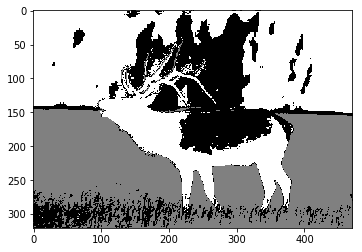

In [97]:
np.random.seed(seed=233423)
im = plt.imread('elk.png')
label0 = cluster_coarse_color_statistics(im, num_segments=3)
labelled_rgb=label2color(im,label0)
plt.imshow(label0/2,'gray')


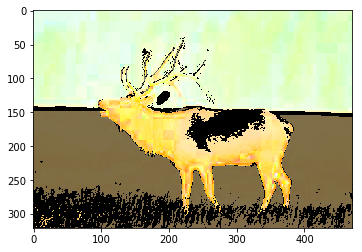

In [86]:
plt.imshow(label2color(im,label0),cmap='gray',vmin=2)

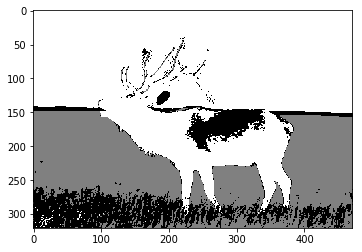